
Circuit Simulation Example with OBI-One
======================================

This notebook demonstrates how to run circuit simulations using the obi-one simulation framework
with [BlueCelluLab](https://github.com/openbraininstitute/BlueCelluLab) as the simulator. Let's get the path to the simulation configuration and circuit configuration file paths and the population name of the circuit that you want to simulate.

For this example, we will use the pre-made `simulation_config.json` (simulation configuration) file instead of the one generated by obi-one.

In [1]:
population_name = "S1nonbarrel_neurons"
circuit_folder = "../data/tiny_circuits/N_10__top_nodes_dim6__asc/"
circuit_config_path = "../data/tiny_circuits/N_10__top_nodes_dim6__asc/circuit_config.json"
simulation_config_path = "../data/tiny_circuits/N_10__top_nodes_dim6__asc/simulation_config.json"

Get the path to the mod files and compile the mod files. 

In [ ]:
# Remove the old compiled mod files folder
! rm -r arm64/
# flag DISABLE_REPORTINGLIB to skip SonataReportHelper.mod and SonataReport.mod from compilation.
!nrnivmodl -incflags "-DDISABLE_REPORTINGLIB" {circuit_folder}/mod 
# !nrnivmodl {circuit_folder}/mod

Import required modules from obi-one

In [ ]:

from obi_one.scientific.simulation.simulations import Simulation
from obi_one.scientific.simulation.stimulus import ConstantCurrentClampSomaticStimulus
from obi_one.scientific.simulation.recording import SomaVoltageRecording
from obi_one.scientific.simulation.timestamps import RegularTimestamps
from obi_one.scientific.circuit.neuron_sets import IDNeuronSet
from obi_one.core.tuple import NamedTuple
from obi_one.scientific.unions.unions_neuron_sets import NeuronSetReference
from obi_one.scientific.unions.unions_timestamps import TimestampsReference
from matplotlib import pyplot as plt


Create the `Simulation` object.

In [4]:
# Create regular timestamps with start, end, and dt
timestamps = RegularTimestamps(
    number_of_repetitions=1, 
    interval=100.0,  # ms
    start_time=0.0,  # ms
    end_time=100.0,  # ms
    dt=0.1,          # ms
    simulation_level_name="timestamps_1"
)

# Create a NamedTuple with the neuron IDs
neuron_ids = NamedTuple(name="neuron_ids", elements=[1, 2, 3])  # List of cell IDs to include

# Create neuron set using IDNeuronSet
neuron_set = IDNeuronSet(
    population=population_name, 
    neuron_ids=neuron_ids,
    simulation_level_name="neuron_set_1"
)

# First, create the timestamps reference
timestamps_ref = TimestampsReference(block=timestamps, block_name="timestamps_1")

# Then create the stimulus with the reference
stimulus = ConstantCurrentClampSomaticStimulus(
    timestamps=timestamps_ref,
    delay=10.0,  # ms
    duration=50.0,  # ms
    amplitude=0.1,  # nA
    neuron_set=NeuronSetReference(block=neuron_set, block_name="neuron_set_1"),
    simulation_level_name="stimulus_1"
)
# Create recordings (example with voltage recording)
recording = SomaVoltageRecording(
    start_time=0.0,
    end_time=100.0,
    dt=0.1,
    neuron_set=NeuronSetReference(block=neuron_set, block_name="neuron_set_1"),
    simulation_level_name="voltage_recording_1"
)

from obi_one.scientific.circuit.circuit import Circuit

# First create the circuit object
circuit = Circuit(
    name="N_10__top_nodes_dim6__asc",
    path=circuit_config_path,
    node_population=population_name,
)

from obi_one.core.info import Info
# Create info object
simulation_info = Info(
    name="N_10__top_nodes_dim6__asc Simulation",
    description="A test simulation with a small microcircuit",
    author="Darshan Mandge",
    version="0.0.1"
)

# Then use it in the simulation initialization
simulation = Simulation(
    name="simulation_1",
    info=simulation_info,
    timestamps={"timestamps_1": timestamps},  # Make sure this matches the block_name
    stimuli={"stimulus_1": stimulus},
    recordings={"voltage_recording_1": recording},
    neuron_sets={"neuron_set_1": neuron_set},
    initialize={
        "circuit": circuit,
        "simulation_length": 100.0,  # ms
        "node_set": NeuronSetReference(block=neuron_set, block_name="neuron_set_1"),
        "timestep": 0.025  # ms
    }
)

If you want to generate configuration uncomment the cell below.

In [5]:
# Generate the simulation configuration
# simulation.generate()

Run circuit simulation using BlueCelluLab backend. In future, we will support Neurodamus backend as well. This will run a SONATA simulation and save voltage traces for the specified cells.  

In [ ]:
# Run the simulation
simulation.run(
    simulation_config=simulation_config_path,
    simulator="bluecellulab", # Optional: bluecellulab or neurodamus. Default: bluecellulab
    save_nwb=False            # Optional: Save results in NWB format. Default: False
    )

The results are stored in the output directory of the circuit folder. The logs are also stored in the logs in notebooks folder.

### Spike Report Analysis using BluePySnap

We will use the example [notebook](https://github.com/openbraininstitute/snap/blob/master/doc/source/notebooks/06_spike_reports.ipynb) from BluePySnap to analyse the spike report generated by the circuit simulation.

In [7]:
import bluepysnap

snap_simulation = bluepysnap.Simulation(simulation_config_path)
spikes = snap_simulation.spikes
print(
    spikes.time_start,
    spikes.time_stop, 
    spikes.dt
)
print(spikes.population_names)

0 3000.0 0.025
['S1nonbarrel_neurons']


See what simulation_config.json file contents:

In [ ]:
snap_simulation.config

In [9]:
spike_pop = spikes['S1nonbarrel_neurons']
print(type(spike_pop))

node_population = spike_pop.nodes
print(f'{node_population.name}: {type(node_population)}')

<class 'bluepysnap.spike_report.PopulationSpikeReport'>
S1nonbarrel_neurons: <class 'bluepysnap.nodes.node_population.NodePopulation'>


ids = spike_pop.node_ids
node_population.get(ids, properties=['layer','synapse_class','x','y','z']).head()

In [10]:
filtered = spikes.filter(group={'layer':'6'}, t_start=spikes.time_start, t_stop=spikes.time_stop)
filtered.report.head()

,ids,population
times,,
1.000000e-10,9,S1nonbarrel_neurons
1.000000e-10,8,S1nonbarrel_neurons
1.000000e-10,7,S1nonbarrel_neurons
1.000000e-10,6,S1nonbarrel_neurons
1.000000e-10,4,S1nonbarrel_neurons


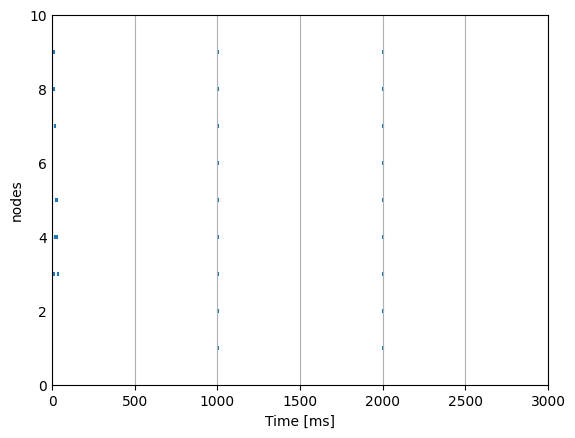

In [11]:
filtered.raster();

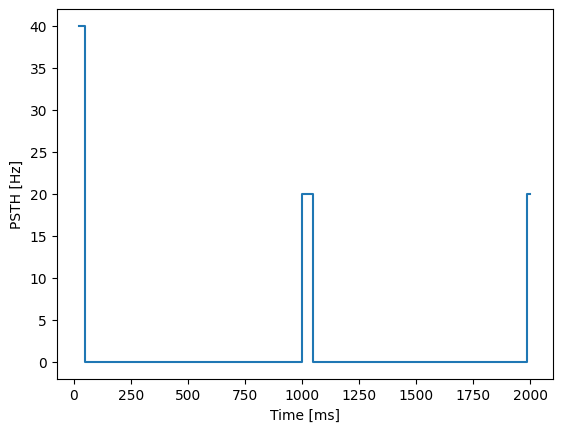

In [12]:
filtered.firing_rate_histogram();

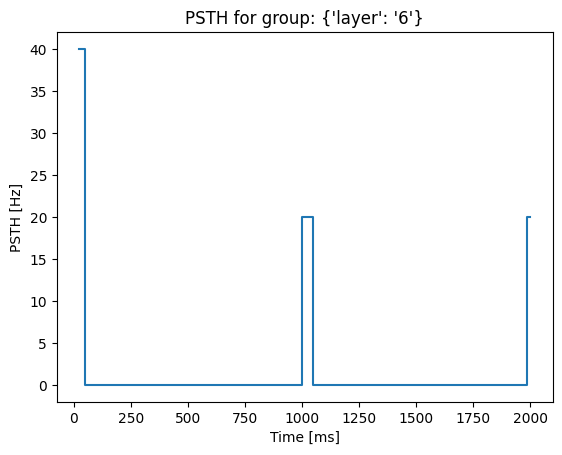

In [13]:
import matplotlib.pyplot as plt
import numpy as np

ax = plt.gca()
ax.set_xlabel("Time [ms]")
ax.set_ylabel("PSTH [Hz]")
ax.set_title(f"PSTH for group: {filtered.group}")

times = filtered.report.index

time_start = np.min(times)
time_stop = np.max(times)

# heuristic for a nice bin size (~100 spikes per bin on average)
time_binsize = min(50.0, (time_stop - time_start) / ((len(times) / 100.0) + 1.0))

bins = np.append(np.arange(time_start, time_stop, time_binsize), time_stop)
hist, bin_edges = np.histogram(times, bins=bins)
node_count = len(snap_simulation.circuit.nodes.ids(filtered.group))  # Get length of node ids for whole `group`
freq = 1.0 * hist / node_count / (0.001 * time_binsize)

# use the middle of the bins instead of the start of the bin
ax.plot(0.5 * (bin_edges[1:] + bin_edges[:-1]), freq, label="PSTH", drawstyle="steps-mid");

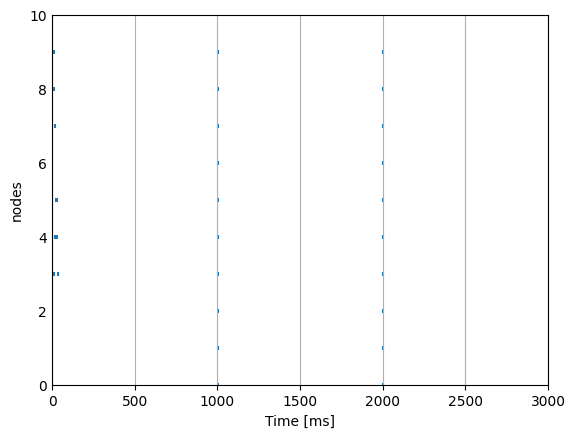

In [14]:
spikes.filter().raster();

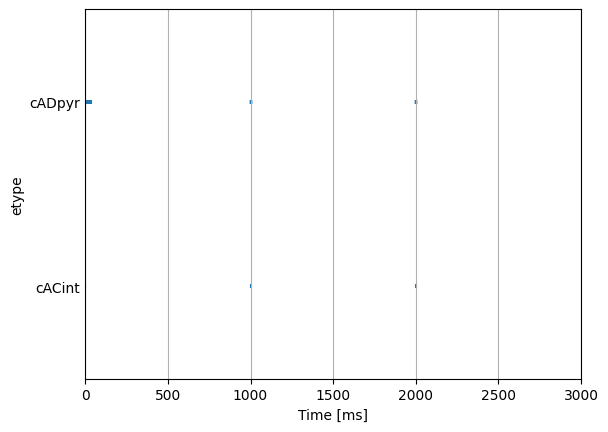

In [15]:
spikes.filter().raster(y_axis='etype');

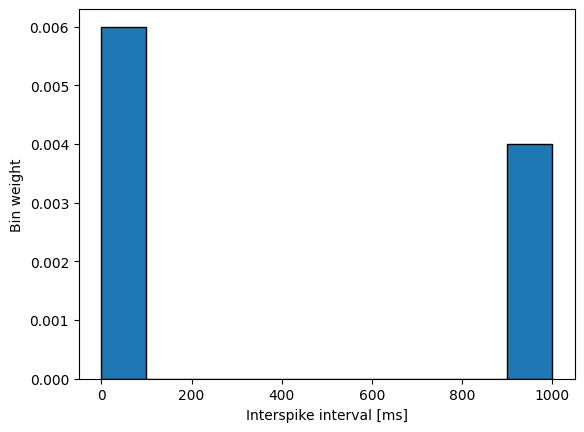

In [16]:
spikes.filter().isi(binsize=100);

### Soma Report Analysis

Let's [load](https://github.com/openbraininstitute/snap/blob/master/doc/source/notebooks/07_frame_reports.ipynb) the soma report using BluePySnap and plot it.

In [17]:
snap_simulation.reports

{'SomaVoltRec': <bluepysnap.frame_report.SomaReport at 0x34aa69490>}

In [18]:
soma_report = snap_simulation.reports['SomaVoltRec']

In [19]:
print(
    soma_report.time_start, 
    soma_report.time_stop, 
    soma_report.dt,
    soma_report.time_units
)  # Gives a warning in case the dt differs from simulation.dt

2025-06-28 14:55:18,995 - bluepysnap.frame_report - WARNING - dt from the report differs from the global simulation dt.
0.0 3000.0 0.1 ms


In [20]:
soma_report.population_names

['S1nonbarrel_neurons']

In [21]:
soma_pop = soma_report['S1nonbarrel_neurons']
print(type(soma_pop))

<class 'bluepysnap.frame_report.PopulationSomaReport'>


In [22]:
node_population = soma_pop.nodes
print(f'{node_population.name}: {type(node_population)}')

S1nonbarrel_neurons: <class 'bluepysnap.nodes.node_population.NodePopulation'>


In [23]:
ids = soma_pop.node_ids
node_population.get(ids, properties=['layer','synapse_class','x','y','z']).head()

,layer,synapse_class,x,y,z
node_ids,,,,,
0,3,INH,4426.676668,-1365.720303,-1999.555547
1,6,EXC,3704.584482,-1105.618485,-2859.425448
2,6,EXC,3592.573893,-1084.057134,-2963.768280
3,6,EXC,3627.362786,-1087.181103,-2897.810749
4,6,EXC,3537.776871,-1029.445880,-2890.783793


In [24]:
filtered = soma_report.filter(group={'layer':'6'}, t_start= soma_report.time_start, t_stop= soma_report.time_stop)
filtered.report.head()

S1nonbarrel_neurons                                              \
                      1          2          3          4          5   
0.0            0.025000   0.025000   0.025000   0.025000   0.025000   
0.1          -75.012161 -81.421906 -74.164589 -73.334396 -73.318329   
0.2          -80.971519 -85.563881 -80.190681 -78.139061 -78.128128   
0.3          -82.381752 -86.438622 -81.931999 -79.541733 -79.488579   
0.4          -82.900101 -86.714569 -82.654526 -80.193848 -80.091064   

                                                 
             6          7          8          9  
0.0   0.025000   0.025000   0.025000   0.025000  
0.1 -72.265778 -68.949173 -75.983292 -74.589790  
0.2 -78.832153 -75.408142 -80.140320 -79.929703  
0.3 -80.837555 -77.539986 -81.345116 -81.573647  
0.4 -81.695602 -78.492760 -81.851669 -82.339790

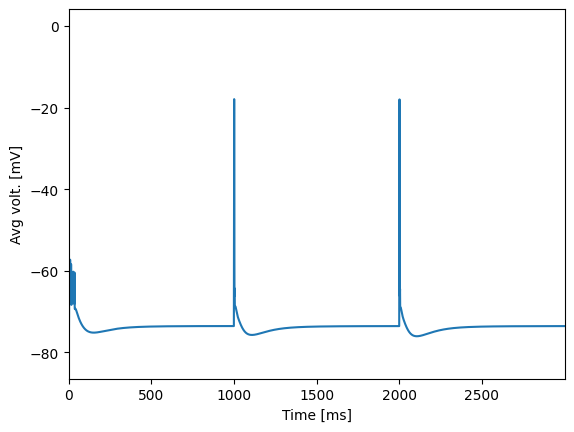

In [25]:
filtered.trace();

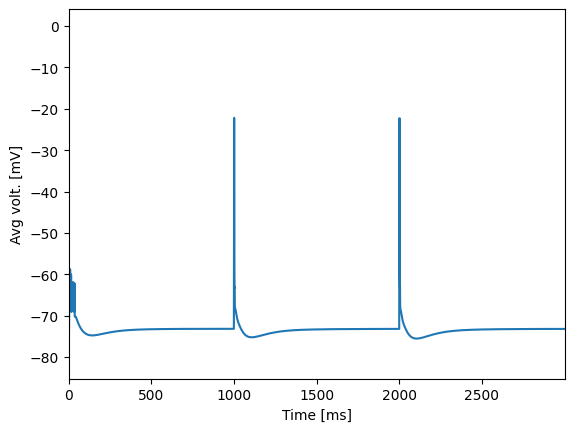

In [26]:
soma_report.filter().trace();